# TLT Classification example usecase

#### This notebook shows an example use case for classification using the Transfer Learning Toolkit. **_It is not optimized for accuracy._**

0. [Set up env variables](#head-0)
1. [Prepare dataset and pretrained model](#head-1)<br>
    1.1 [Split the dataset into train/test/val](#head-1-1)<br>
    1.2 [Download pre-trained model](#head-1-2)<br>
2. [Provide training specfication](#head-2)
3. [Run TLT training](#head-3)
4. [Evaluate trained models](#head-4)
5. [Prune trained models](#head-5)
6. [Retrain pruned models](#head-6)
7. [Testing the model](#head-7)
8. [Visualize inferences](#head-8)
0. [Export and Deploy!](#head-9)

## 0. Setup env variables <a class="anchor" id="head-0"></a>

Please replace the **$API_KEY** with your api key on **ngc.nvidia.com**

In [351]:
%env USER_EXPERIMENT_DIR=/workspace/data/w251-accident-detection
%env DATA_DOWNLOAD_DIR=/workspace/data/w251-accident-detection/dataset2
%env SPECS_DIR=/workspace/examples/specs
%env API_KEY=YjE4M2VtdnYzYjBycTVyMDg2MGJtMGV1OHQ6NTY5MWUxODktN2I4My00MTAyLThlNDgtZThhMzNlN2M2Yjgw
%env MODEL_NAME=resnet50
%env ARCH_VER=resnet_001.tlt

env: USER_EXPERIMENT_DIR=/workspace/data/w251-accident-detection
env: DATA_DOWNLOAD_DIR=/workspace/data/w251-accident-detection/dataset2
env: SPECS_DIR=/workspace/examples/specs
env: API_KEY=YjE4M2VtdnYzYjBycTVyMDg2MGJtMGV1OHQ6NTY5MWUxODktN2I4My00MTAyLThlNDgtZThhMzNlN2M2Yjgw
env: MODEL_NAME=resnet50
env: ARCH_VER=resnet_001.tlt


In [308]:
%env SAMPLE_FOLDER=/workspace/data/video_sample_test/frames_1fps

env: SAMPLE_FOLDER=/workspace/data/video_sample_test/frames_1fps


### 1.2 Download pretrained models <a class="anchor" id="head-1-2"></a>

Print the list of available models. Find your **ORG** and **TEAM** on ngc.nvidia.com and replace the **-o** and **-t** arguments.

In [3]:
!tlt-pull -k $API_KEY -lm -o nvtltea -t iva

+----------+----------+---------+----------+----------+----------+----------+
| Name     | Org/Team | Latest  | Applicat | Framewor | Precisio | Last     |
|          |          | Version | ion      | k        | n        | Modified |
+----------+----------+---------+----------+----------+----------+----------+
| tlt_iva_ | nvtltea/ | 1       | Classifi | TLT      | FP32     | 2019-03- |
| classifi | iva      |         | cation   |          |          | 01       |
| cation_a |          |         |          |          |          | 20:41:41 |
| lexnet   |          |         |          |          |          | UTC      |
| tlt_iva_ | nvtltea/ | 1       | Classifi | TLT      | FP32     | 2019-03- |
| classifi | iva      |         | cation   |          |          | 02       |
| cation_g |          |         |          |          |          | 00:08:48 |
| ooglenet |          |         |          |          |          | UTC      |
| tlt_iva_ | nvtltea/ | 1       | Classifi | TLT      | FP32    

Download the resnet18 classification model.

In [134]:
!tlt-pull -d $USER_EXPERIMENT_DIR -k $API_KEY  -m tlt_iva_classification_vgg19 -v 1 -o nvtltea -t iva

Downloaded 142.73 MB in 9s, Download speed: 15.82 MB/s               
----------------------------------------------------
Transfer id: tlt_iva_classification_vgg19_v1 Download status: Completed.
Downloaded local path: /tmp/tmplGLXTh/tlt_iva_classification_vgg19_v1
Total files downloaded: 2 
Total downloaded size: 142.73 MB
Started at: 2019-04-12 04:38:48.999117
Completed at: 2019-04-12 04:38:58.019796
Duration taken: 9s seconds
----------------------------------------------------
Finished downloading tlt_iva_classification_vgg19


In [175]:
print("Check that model is downloaded into dir.")
!ls -l $USER_EXPERIMENT_DIR

Check that model is downloaded into dir.
total 715060
drwxr-xr-x 5 root root      4096 Apr  8 06:47 dataset
drwxrwxrwx 5 root root      4096 Apr 11 16:09 dataset2
-rw-r--r-- 1 root root  50060624 Apr  8 14:34 googlenet_v1.tlt
-rw-r--r-- 1 root root       250 Apr 12 04:38 license.txt
drwxr-xr-x 4 root root      4096 Apr 11 18:20 output
drwxr-xr-x 3 root root      4096 Apr 12 05:47 output_resnet50
drwxr-xr-x 3 root root      4096 Apr  8 09:57 output_retrain
drwxr-xr-x 3 root root      4096 Apr 12 03:43 output_vgg16
drwxr-xr-x 3 root root      4096 Apr 12 04:53 output_vgg19
-rw-r--r-- 1 root root  93345080 Apr 10 18:45 resnet18_v1.tlt
-rw-r--r-- 1 root root 308837552 Apr 11 18:17 resnet50_v1.tlt
-rw-r--r-- 1 root root 118697048 Apr 12 03:39 vgg16_v1.tlt
-rw-r--r-- 1 root root 161239344 Apr 12 04:38 vgg19_v1.tlt


## 2. Provide training specfication <a class="anchor" id="head-2"></a>
* Training dataset
* Validation dataset
* Pre-trained models
* Other training (hyper-)parameters such as batch size, number of epochs, learning rate etc.

In [352]:
!cat $SPECS_DIR/classification_spec.cfg

model_config {
  arch: "resnet",
  n_layers: 50
  input_image_size: "3,224,224"
}
train_config {
  train_dataset_path: "/workspace/data/w251-accident-detection/dataset2/train"
  val_dataset_path: "/workspace/data/w251-accident-detection/dataset2/val"
  pretrained_model_path: "/workspace/data/w251-accident-detection/resnet50_v1.tlt"
  optimizer: "sgd"
  batch_size_per_gpu: 64
  n_epochs: 10
  n_workers: 16

  # regularizer
  reg_config {
    type: "L2"
    scope: "Conv2D,Dense"
    weight_decay: 0.00005
  }

  # learning_rate
  lr_config {
    scheduler: "step"
    learning_rate: 0.006
    #soft_start: 0.056
    #annealing_points: "0.3, 0.6, 0.8"
    #annealing_divider: 10
    step_size: 10
    gamma: 0.1
  }
}


## 3. Run TLT training <a class="anchor" id="head-3"></a>
* Provide the sample spec file and the output directory location for models

In [353]:
!rm -r $USER_EXPERIMENT_DIR/output_$MODEL_NAME

In [354]:
print('Create an output dir')
!mkdir $USER_EXPERIMENT_DIR/output_$MODEL_NAME

Create an output dir


In [355]:
print('Model checkpoints and logs:')
print('---------------------')
!ls -l $USER_EXPERIMENT_DIR/output_$MODEL_NAME

Model checkpoints and logs:
---------------------
total 0


### Please change the **train_dataset_path, val_dataset_path, pretrained_model_path** in the spec file below if these values are different. 

In [356]:
print("Check spec file")

!cat $SPECS_DIR/classification_spec.cfg

Check spec file
model_config {
  arch: "resnet",
  n_layers: 50
  input_image_size: "3,224,224"
}
train_config {
  train_dataset_path: "/workspace/data/w251-accident-detection/dataset2/train"
  val_dataset_path: "/workspace/data/w251-accident-detection/dataset2/val"
  pretrained_model_path: "/workspace/data/w251-accident-detection/resnet50_v1.tlt"
  optimizer: "sgd"
  batch_size_per_gpu: 64
  n_epochs: 10
  n_workers: 16

  # regularizer
  reg_config {
    type: "L2"
    scope: "Conv2D,Dense"
    weight_decay: 0.00005
  }

  # learning_rate
  lr_config {
    scheduler: "step"
    learning_rate: 0.006
    #soft_start: 0.056
    #annealing_points: "0.3, 0.6, 0.8"
    #annealing_divider: 10
    step_size: 10
    gamma: 0.1
  }
}


In [357]:
!tlt-train classification -e $SPECS_DIR/classification_spec.cfg \
-r $USER_EXPERIMENT_DIR/output_$MODEL_NAME \
-k $API_KEY

Using TensorFlow backend.
--------------------------------------------------------------------------
[[21686,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: f2659f2d8216

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------
2019-04-15 09:24:18.850286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:898] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-04-15 09:24:18.851223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1356] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:07.0
totalMemory: 15.90GiB

Epoch 1/10
2019-04-15 09:25:27.324555: W tensorflow/core/common_runtime/bfc_allocator.cc:219] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2019-04-15 09:25:27.401225: W tensorflow/core/common_runtime/bfc_allocator.cc:219] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.40GiB. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
235/235 [==============================] - 247s 1s/step - loss: 0.5682 - acc: 0.8466 - val_loss: 0.4433 - val_acc: 0.9206
Epoch 2/10
235/235 [==============================] - 204s 867ms/step - loss: 0.4057 - acc: 0.9341 - val_loss: 0.3932 - val_acc: 0.9398
Epoch 3/10
235/235 [==============================] - 201s 854ms/step - loss: 0.3770 - acc: 0.9498 - val_loss: 0.3905 - val_acc: 0.9408
Epoch 4/10
235/235 [===========

## 4. Evaluate trained models <a class="anchor" id="head-4"></a>

In [358]:
!tlt-evaluate classification -d $DATA_DOWNLOAD_DIR/test \
                             -pm $USER_EXPERIMENT_DIR/output_$MODEL_NAME/weights/$ARCH_VER \
                             -b 32 -k $API_KEY

Using TensorFlow backend.
--------------------------------------------------------------------------
[[8240,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: f2659f2d8216

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------
2019-04-15 10:28:47.776991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:898] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-04-15 10:28:47.777941: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1356] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:07.0
totalMemory: 15.90GiB 

Found 1878 images belonging to 2 classes.
2019-04-15 10:29:11,005 [INFO] /usr/local/lib/python2.7/dist-packages/iva/makenet/scripts/evaluate.pyc: Processing dataset (evaluation): /workspace/data/w251-accident-detection/dataset2/test
2019-04-15 10:29:25,743 [INFO] /usr/local/lib/python2.7/dist-packages/iva/makenet/scripts/evaluate.pyc: Total evaluation Loss: 0.465545535088
2019-04-15 10:29:25,744 [INFO] /usr/local/lib/python2.7/dist-packages/iva/makenet/scripts/evaluate.pyc: Total evaluation accuracy: 0.916400432587


In [362]:
!tlt-infer classification -m $USER_EXPERIMENT_DIR/output_$MODEL_NAME/weights/$ARCH_VER \
                          -k $API_KEY -b 32 \
                          -d $DATA_DOWNLOAD_DIR/test/collision \
                          -cm $USER_EXPERIMENT_DIR/output_$MODEL_NAME/classmap.json

Using TensorFlow backend.
2019-04-15 16:21:52.651835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:898] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-04-15 16:21:52.652815: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1356] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:07.0
totalMemory: 15.90GiB freeMemory: 15.39GiB
2019-04-15 16:21:52.763480: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:898] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-04-15 16:21:52.764440: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1356] Found device 1 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:08.0
totalMemory: 15.90GiB freeMemory: 15.64GiB
2019-04-15 16:21:5

In [363]:
import numpy as np
import pandas as pd
import os
result_path = os.path.join(os.getenv('DATA_DOWNLOAD_DIR'),'test','collision','result.csv')
result_df = pd.read_csv(result_path,header = None,names = ['id','path','label'])
vid_name = []
for vid in result_df.path:
    vid_name.append(os.path.basename(vid))
result_df['vid'] = vid_name

result_df.head(1)

id                                               path      label  \
0   0  /workspace/data/w251-accident-detection/datase...  collision   

              vid  
0  000000_658.jpg

#### TEST ON THE SAMPLE VIDEO

In [316]:
#!rm /workspace/data/video_sample_test/frames_1fps/result.csv
!tlt-infer classification -m $USER_EXPERIMENT_DIR/output_$MODEL_NAME/weights/$ARCH_VER \
                          -k $API_KEY -b 32 \
                          -d $SAMPLE_FOLDER \
                          -cm $USER_EXPERIMENT_DIR/output_$MODEL_NAME/classmap.json
!cp /workspace/data/video_sample_test/frames_1fps/result.csv /workspace/data/video_sample_test/frames_1fps/result_$MODEL_NAME.csv 
!rm /workspace/data/video_sample_test/frames_1fps/result.csv

Using TensorFlow backend.
2019-04-15 08:48:53.580336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:898] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-04-15 08:48:53.581279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1356] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:07.0
totalMemory: 15.90GiB freeMemory: 15.39GiB
2019-04-15 08:48:53.681797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:898] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-04-15 08:48:53.682776: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1356] Found device 1 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:08.0
totalMemory: 15.90GiB freeMemory: 15.64GiB
2019-04-15 08:48:5

In [317]:
import numpy as np
import pandas as pd
import os
result_path = '/workspace/data/video_sample_test/frames_1fps/result_'+os.getenv('MODEL_NAME')+'.csv'
result_df = pd.read_csv(result_path,header = None,names = ['id','path','label'])
vid_name = []
for vid in result_df.path:
    vid_name.append(os.path.basename(vid))
result_df['vid'] = vid_name

result_df.head(1)

id                                               path         label  \
0   0  /workspace/data/video_sample_test/frames_1fps/...  no_collision   

            vid  
0  vid_0001.jpg

In [318]:
truth_table = pd.read_csv("/workspace/data/video_sample_test/video_sample_labels_actuals_1fps.csv")

vid_name = []
for vid in truth_table.url:
    vid_name.append(os.path.basename(vid))
truth_table['vid'] = vid_name
truth_table['label_act'] = truth_table.label_act.str.replace('no collision','no_collision')
#truth_table.label_act[truth_table.label_act=='no collision'] = 'no_collision'
truth_table.head(10)

url  inference_time  \
0  /home/saifrais/w251/final_project/data/video_s...           0.723   
1  /home/saifrais/w251/final_project/data/video_s...           0.724   
2  /home/saifrais/w251/final_project/data/video_s...           0.683   
3  /home/saifrais/w251/final_project/data/video_s...           0.736   
4  /home/saifrais/w251/final_project/data/video_s...           0.704   
5  /home/saifrais/w251/final_project/data/video_s...           0.771   
6  /home/saifrais/w251/final_project/data/video_s...           0.754   
7  /home/saifrais/w251/final_project/data/video_s...           0.768   
8  /home/saifrais/w251/final_project/data/video_s...           0.758   
9  /home/saifrais/w251/final_project/data/video_s...           0.706   

     label_pred     prob     label_act          note           vid  
0     collision  0.96761  no_collision  title screen  vid_0001.jpg  
1     collision  0.96795  no_collision  title screen  vid_0002.jpg  
2     collision  0.96818  no_collision  title screen  vid_0003.jpg  
3     collision  0.96764  no_collision  title screen  vid_0004.jpg  
4  no collision  0.89994  no_collision  title screen  vid_0005.jpg  
5     collision  0.98697  no_collision           NaN  vid_0006.jpg  
6     collision  0.98057  no_collision           NaN  vid_0007.jpg  
7     collision  0.98505  no_collision           NaN  vid_0008.jpg  
8     collision  0.99365  no_collision           NaN  vid_0009.jpg  
9     collision  0.98213     collision    car on car  vid_0010.jpg

In [319]:
mdf = pd.merge(truth_table, result_df[['vid','label']], on = 'vid', how = 'left')
mdf.head(1)

url  inference_time  \
0  /home/saifrais/w251/final_project/data/video_s...           0.723   

  label_pred     prob     label_act          note           vid         label  
0  collision  0.96761  no_collision  title screen  vid_0001.jpg  no_collision

In [320]:
from sklearn import metrics
class_report = metrics.classification_report(mdf.label_act,mdf.label)
accuracy = metrics.accuracy_score(mdf['label_act'],mdf['label'])
precision = metrics.precision_score(mdf['label_act'],mdf['label'],average="binary", pos_label="collision")
recall = metrics.recall_score(mdf['label_act'],mdf['label'],average="binary", pos_label="collision")
f1 = metrics.f1_score(mdf.label_act,mdf.label,average="binary", pos_label="collision")
print(class_report)
#print(recall)
#print(accuracy)
#print(recall)
#print(f1)
print("Accuracy:{:.3f} Precision:{:.3f} Recall:{:.3f} F1 score:{:.3f}".format(accuracy,precision,recall,f1))


              precision    recall  f1-score   support

   collision       0.78      0.47      0.59       440
no_collision       0.42      0.74      0.54       230

   micro avg       0.57      0.57      0.57       670
   macro avg       0.60      0.61      0.56       670
weighted avg       0.66      0.57      0.57       670

Accuracy:0.566 Precision:0.779 Recall:0.473 F1 score:0.588


### VIDEO FRAME ERRORS

In [340]:
filtered_df = mdf[mdf.label_act!=mdf.label]
filtered_df.head(10)

url  inference_time  \
9   /home/saifrais/w251/final_project/data/video_s...           0.706   
10  /home/saifrais/w251/final_project/data/video_s...           0.675   
11  /home/saifrais/w251/final_project/data/video_s...           0.672   
12  /home/saifrais/w251/final_project/data/video_s...           0.688   
13  /home/saifrais/w251/final_project/data/video_s...           0.680   
14  /home/saifrais/w251/final_project/data/video_s...           0.703   
26  /home/saifrais/w251/final_project/data/video_s...           0.727   
29  /home/saifrais/w251/final_project/data/video_s...           0.753   
30  /home/saifrais/w251/final_project/data/video_s...           0.748   
31  /home/saifrais/w251/final_project/data/video_s...           0.754   

      label_pred     prob     label_act  \
9      collision  0.98213     collision   
10     collision  0.98528     collision   
11     collision  0.97134     collision   
12     collision  0.98514     collision   
13     collision  0.87418     collision   
14     collision  0.93615     collision   
26  no collision  0.93171  no_collision   
29  no collision  0.97008  no_collision   
30  no collision  0.99047  no_collision   
31  no collision  0.93675     collision   

                                     note           vid         label  
9                              car on car  vid_0010.jpg  no_collision  
10                             car on car  vid_0011.jpg  no_collision  
11                             car on car  vid_0012.jpg  no_collision  
12                             car on car  vid_0013.jpg  no_collision  
13                             car on car  vid_0014.jpg  no_collision  
14                             car on car  vid_0015.jpg  no_collision  
26                                    NaN  vid_0027.jpg     collision  
29                                    NaN  vid_0030.jpg     collision  
30                                    NaN  vid_0031.jpg     collision  
31  bike collision behind a traffic light  vid_0032.jpg  no_collision

In [347]:
filtered_df[filtered_df.label_act=='collision'].shape

(232, 8)

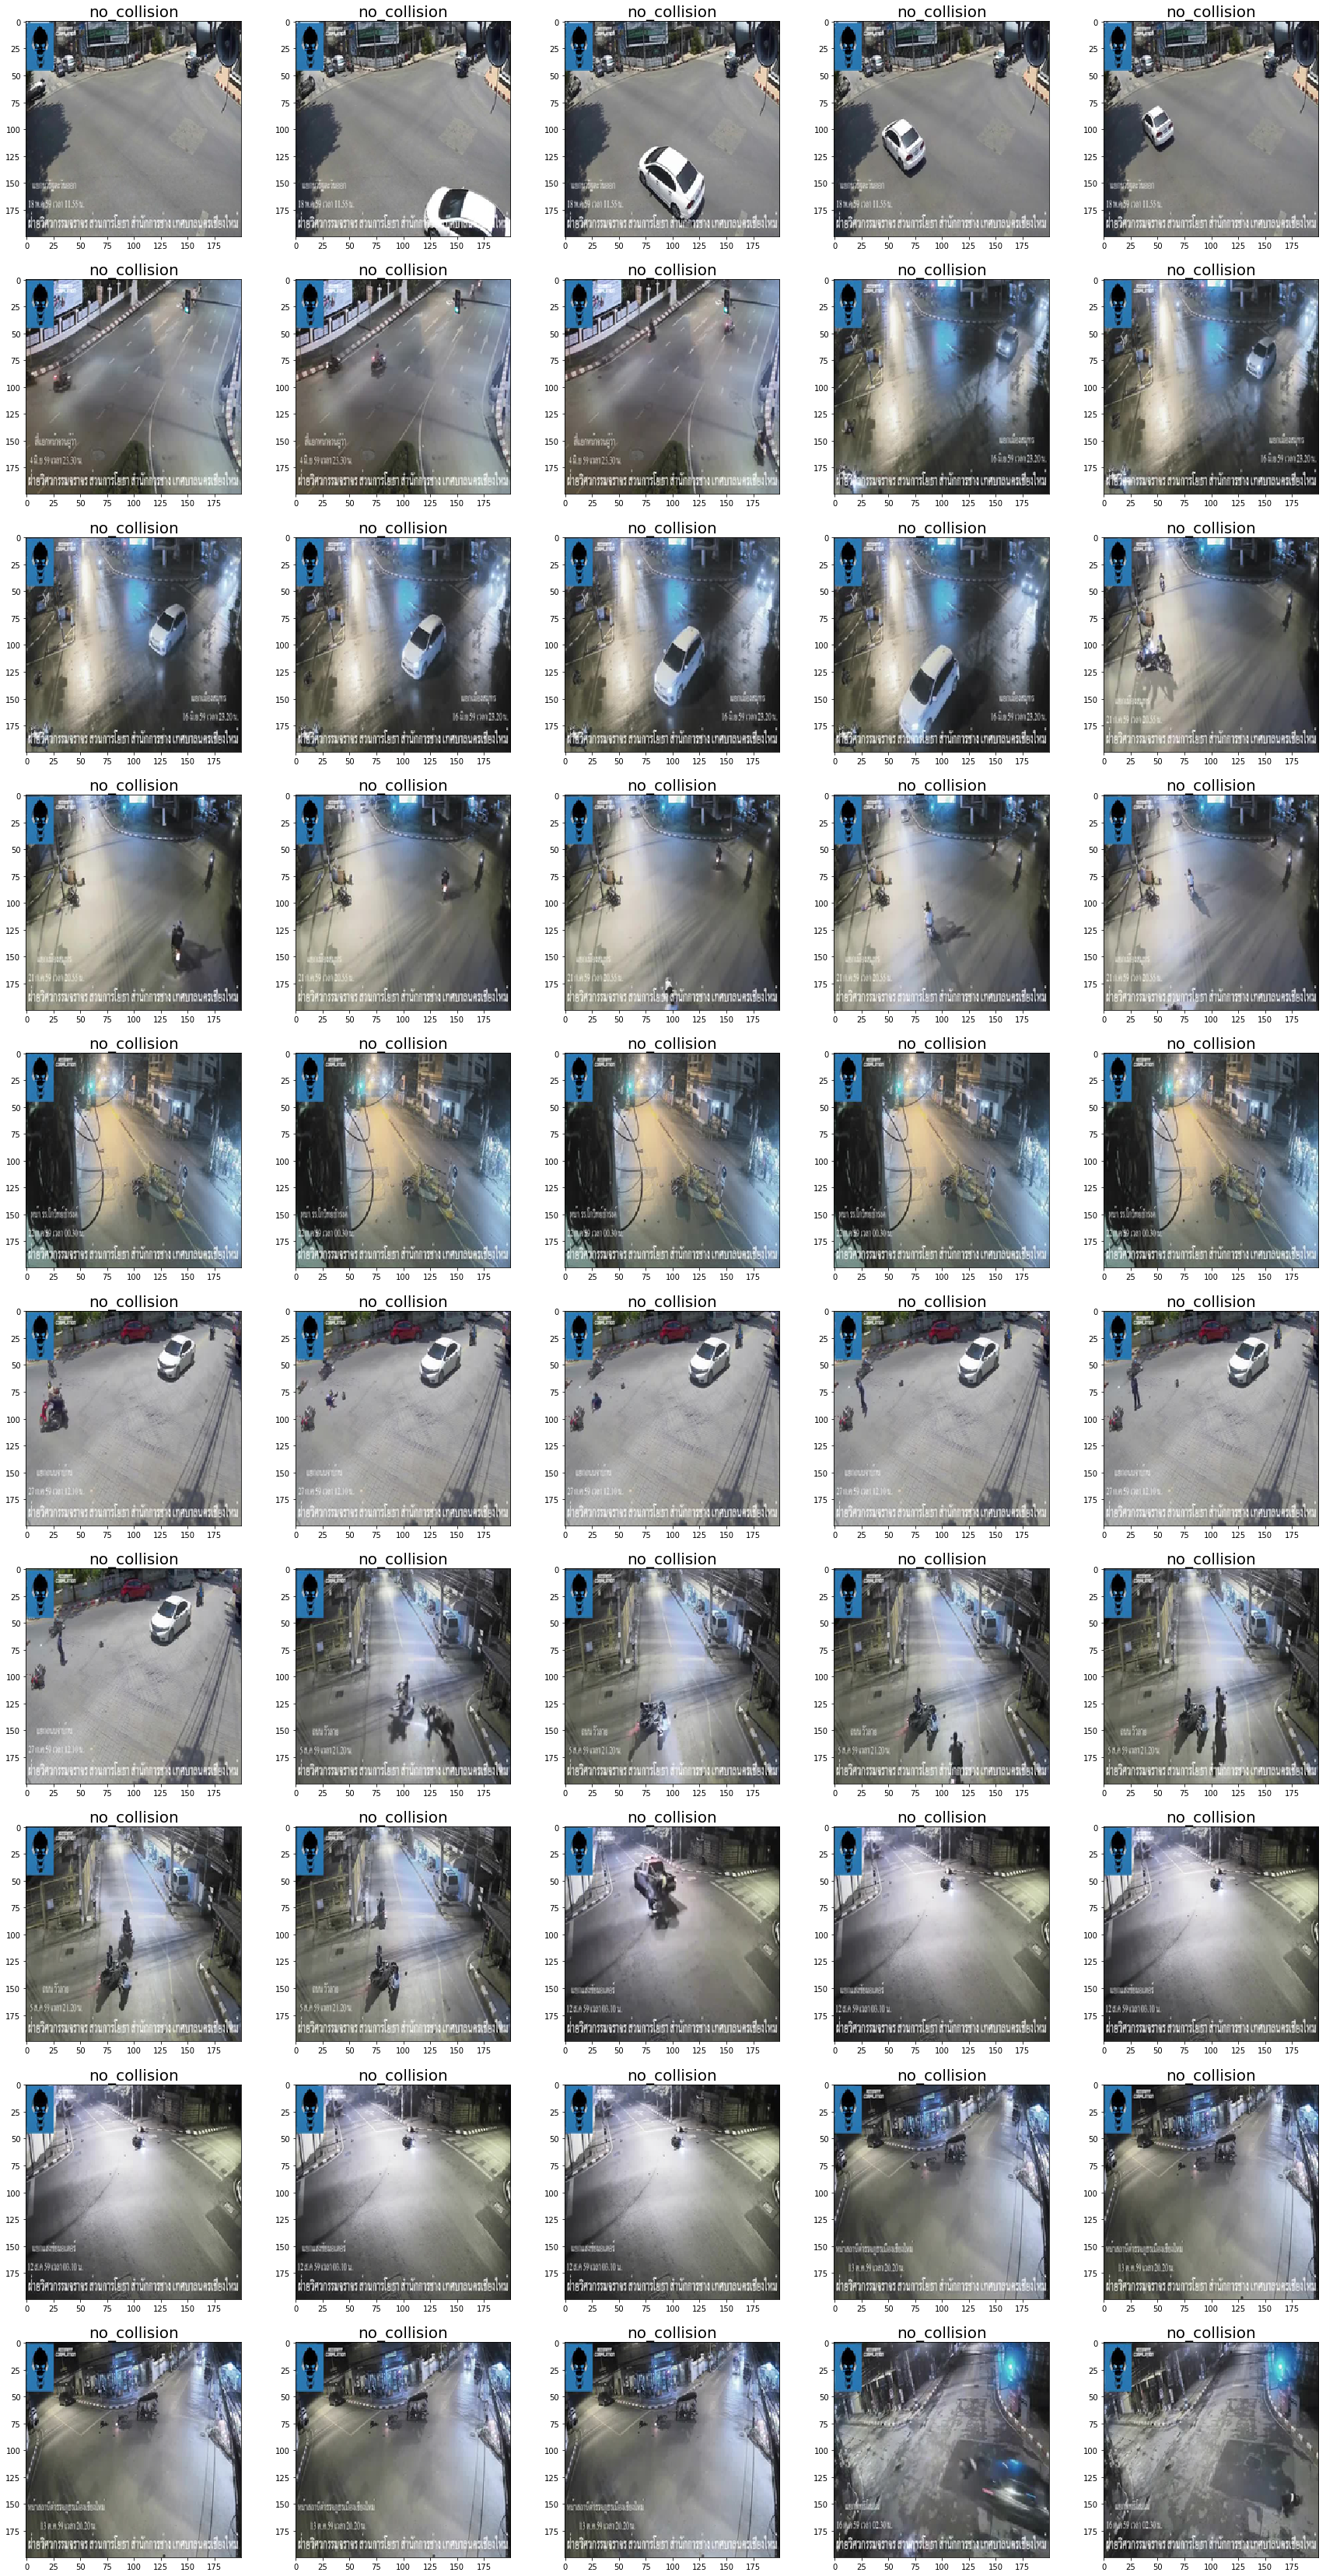

In [350]:
import matplotlib.pyplot as plt
from PIL import Image 
import os
import csv
from math import ceil
class_name = 'collision'
w,h = 200,200
fig = plt.figure(figsize=(30,60))
columns = 5
rows = 10
for i in range(1, columns*rows + 1):
    ax = fig.add_subplot(rows, columns,i)
    vid_name = os.path.basename(filtered_df[filtered_df.label_act==class_name].iloc[i,0])
    tpath = os.path.join('/workspace/data/video_sample_test/frames_1fps',vid_name)
    img = Image.open(tpath)
    img = img.resize((w,h), Image.ANTIALIAS)
    plt.imshow(img)
    ax.set_title(filtered_df[filtered_df.label_act==class_name].iloc[i,7], fontsize=20)

In [189]:
def save_obj(obj, storeloc = "dict.pickle"):
    import pickle
    pickle_out = open(storeloc,"wb")
    pickle.dump(obj, pickle_out)
    print('{} saved'.format(storeloc))
    pickle_out.close()
    
def load_obj(storeloc="accident_df.pickle"):
    import pickle
    import pandas as pd
    pickle_in = open(storeloc,"rb")
    obj = pickle.load(pickle_in)
    print('{} loaded'.format(storeloc))
    return obj

In [190]:
report_path = '/workspace/data/classification_reports/'+os.getenv('MODEL_NAME')+'.pickle'
save_obj(class_report,report_path)

/workspace/data/classification_reports/resnet18.pickle saved


In [191]:
resnet50_class = load_obj('/workspace/data/classification_reports/resnet50.pickle')
vgg16_class = load_obj('/workspace/data/classification_reports/vgg16.pickle')
resnet18_class = load_obj('/workspace/data/classification_reports/resnet18.pickle')

/workspace/data/classification_reports/resnet50.pickle loaded
/workspace/data/classification_reports/vgg16.pickle loaded
/workspace/data/classification_reports/resnet18.pickle loaded


### MODEL PERFORMANCE ON SAMPLE VIDEO

### RESNET-18

In [321]:
print(resnet18_class)

              precision    recall  f1-score   support

   collision       0.79      0.46      0.58       440
no_collision       0.42      0.76      0.54       230

   micro avg       0.56      0.56      0.56       670
   macro avg       0.60      0.61      0.56       670
weighted avg       0.66      0.56      0.57       670



### RESNET-50

In [193]:
print(resnet50_class)

              precision    recall  f1-score   support

   collision       0.79      0.59      0.68       440
no_collision       0.47      0.69      0.56       230

   micro avg       0.63      0.63      0.63       670
   macro avg       0.63      0.64      0.62       670
weighted avg       0.68      0.63      0.64       670



### VGG-16

In [194]:
print(vgg16_class)

              precision    recall  f1-score   support

   collision       0.89      0.44      0.59       440
no_collision       0.45      0.90      0.60       230

   micro avg       0.59      0.59      0.59       670
   macro avg       0.67      0.67      0.59       670
weighted avg       0.74      0.59      0.59       670



## 5. Prune trained models <a class="anchor" id="head-5"></a>
* Specify pre-trained model
* Equalization criterion
* Threshold for pruning
* Exclude prediction layer that you don't want pruned (e.g. predictions)

In [ ]:
!tlt-prune -pm $USER_EXPERIMENT_DIR/output/weights/resnet_001.tlt \
                -o $USER_EXPERIMENT_DIR/output/resnet_001_pruned \
                -eq union \
                -pth 0.7 -k $API_KEY

In [ ]:
print('Pruned model:')
print('------------')
!ls -1 $USER_EXPERIMENT_DIR/output/resnet_001_pruned

## 6. Retrain pruned models <a class="anchor" id="head-6"></a>
* Model needs to be re-trained to bring back accuracy after pruning
* Specify re-training specification

### Please change the **train_dataset_path, val_dataset_path, pretrained_model_path** in the spec file below if these values are different. 

In [ ]:
!cat $SPECS_DIR/classification_retrain_spec.cfg

In [ ]:
!tlt-train classification -e $SPECS_DIR/classification_retrain_spec.cfg -r $USER_EXPERIMENT_DIR/output_retrain -k $API_KEY

## 7. Testing the model! <a class="anchor" id="head-7"></a>

In [ ]:
!tlt-evaluate classification -d $DATA_DOWNLOAD_DIR/split/test \
                               -pm $USER_EXPERIMENT_DIR/output_retrain/weights/resnet_001.tlt \
                               -b 32 -k $API_KEY

## 8. Visualize Inferences <a class="anchor" id="head-8"></a>

To see the output results of our model on test images, we can use the tlt-infer tool. Note that using models trained for higher epochs will result in better results. We'll run inference on a directory of images.

In [ ]:
!tlt-infer classification -m $USER_EXPERIMENT_DIR/output_retrain/weights/resnet_001.tlt \
                          -k $API_KEY -b 32 -d $DATA_DOWNLOAD_DIR/split/test/person \
                          -cm $USER_EXPERIMENT_DIR/output_retrain/classmap.json

Optionally, you can also run inference on a single image. Uncomment the code below for an example.

In [ ]:
#!tlt-infer classification -m $USER_EXPERIMENT_DIR/output_retrain/weights/resnet_001.tlt \
#                          -k $API_KEY -b 32 -i $DATA_DOWNLOAD_DIR/split/test/person/2008_000032.jpg \
#                          -cm $USER_EXPERIMENT_DIR/output_retrain/classmap.json

As explained in Getting Started Guide, this outputs a results.csv file in the same directory. We can use a simple python program to see the visualize the output of csv file.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image 
import os
import csv
from math import ceil

DATA_DIR = os.environ.get('DATA_DOWNLOAD_DIR')
csv_path = os.path.join(DATA_DIR, 'split', 'test', 'person', 'result.csv')
results = []
with open(csv_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        results.append((row[1], row[2]))

w,h = 200,200
fig = plt.figure(figsize=(30,30))
columns = 5
rows = 1
for i in range(1, columns*rows + 1):
    ax = fig.add_subplot(rows, columns,i)
    img = Image.open(results[i][0])
    img = img.resize((w,h), Image.ANTIALIAS)
    plt.imshow(img)
    ax.set_title(results[i][1], fontsize=40)

## 9. Export and Deploy! <a class="anchor" id="head-9"></a>

In [ ]:
!tlt-export $USER_EXPERIMENT_DIR/output_retrain/weights/resnet_001.tlt \
                --input_dim 3,224,224 \
                -o $USER_EXPERIMENT_DIR/export/final_model.uff \
                --enc_key $API_KEY \
                --outputs predictions/Softmax

In [199]:
!tlt-export $USER_EXPERIMENT_DIR/output_resnet50/weights/resnet_001.tlt \
                --input_dim 3,224,224 \
                -o $USER_EXPERIMENT_DIR/export/final_model_resnet50.uff \
                --enc_key $API_KEY \
                --outputs predictions/Softmax

Using TensorFlow backend.
2019-04-12 15:57:52,399 [INFO] magnet.encoding.magnet_export: Loading model from /workspace/data/w251-accident-detection/output_resnet50/weights/resnet_001.tlt
2019-04-12 15:57:55.800212: W tensorflow/stream_executor/cuda/cuda_driver.cc:527] A non-primary context 0x5988d60 for device 0 exists before initializing the StreamExecutor. The primary context is now 0x5954860. We haven't verified StreamExecutor works with that.
2019-04-12 15:57:55.801156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:898] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-04-12 15:57:55.802115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1356] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:07.0
totalMemory: 15.90GiB freeMemory: 15.39GiB
2019-04-12 15:57:55.899189: I tensorflow/stream_executor/cuda/cuda_gpu_e

In [ ]:
print('Exported model:')
print('------------')
!ls -lh $USER_EXPERIMENT_DIR/export/